# **💼Python aplicado a finanzas: fundamentos esenciales para optimizar tu portafolio PARTE II🐍**

##### Autor: Jose Diego Cazares Minjares

##### Contacto: [LinkedIn](https://www.linkedin.com/in/cazaresminjares/) Sitio Web: [betafinanciera.com](https://betafinanciera.com/)

### 1️⃣ Del dato al trade: descarga, analiza, optimiza y traduce pesos a órdenes reales con pypfopt.



### Objetivos breves:

### •	Construir y comparar 3 portafolios para NVDA, JNJ, AAPL, JPM (últimos 5 años).

### •	Optimización por Sortino ratio (máx.).

### •	Optimización por CVaR (minimizar CVaR) y luego max Sharpe sobre esos retornos.

### •	Una cartera “libre” (por Sharpe) para comparación.

### •	Traducir pesos a órdenes para inversión total de $10,000 (DiscreteAllocation).

### •	Finalmente añadir restricciones del mundo real (límites por activo y sector) y comparar.



### 2️⃣ Preparar entorno y descargar datos.

### Descargar precios ajustados de los últimos 5 años para NVDA, JNJ, AAPL, JPM. Limpiar y mostrar primera vista.

In [49]:
# Importar las paqueterias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from pypfopt import expected_returns, risk_models, EfficientFrontier, plotting
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

# Para optimizaciones personalizadas
from scipy.optimize import minimize

In [50]:
# Definir Activos y Periodos
tickers = ["NVDA", "JNJ", "AAPL", "JPM"]
start_date = "2020-10-01"
end_date = None  # hasta hoy

# Descarga de precios ajustados.
prices = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)["Close"]
prices = prices.dropna(how="all")
print("Precios (últimas filas):")
print(prices.tail())

[*********************100%***********************]  4 of 4 completed

Precios (últimas filas):
Ticker            AAPL         JNJ         JPM        NVDA
Date                                                      
2025-10-17  252.289993  193.220001  297.559998  183.220001
2025-10-20  262.239990  193.720001  302.359985  182.639999
2025-10-21  262.769989  191.880005  297.089996  181.160004
2025-10-22  258.450012  192.940002  294.109985  180.279999
2025-10-23  259.860596  192.220001  294.894989  181.774994


### 3️⃣ Optimizar por Sortino ratio.

### Sortino ratio mide retorno ajustado por la volatilidad negativa (solo considera las desviaciones por debajo de un objetivo), útil cuando te preocupan pérdidas más que variabilidad total.

### Fórmula (Sortino):
<br/>

## $$ \frac{\mathbb{E}[R_p] - R_f}{\sigma_d}
 $$
<br/>

### S > 1: excelente | El portafolio genera rendimientos significativamente superiores al riesgo de pérdidas. Ideal para estrategias conservadoras o de preservación de capital.

### 0.5 < S ≤ 1: bueno | El rendimiento ajustado por riesgo negativo es aceptable. El portafolio compensa razonablemente las caídas.

### 0 < S ≤ 0.5: modesto | El rendimiento apenas supera el riesgo de pérdidas. Puede requerir ajustes en la selección de activos o en la estrategia de asignación.

### S ≤ 0: bajo o negativo | El portafolio no compensa el riesgo de pérdidas. Indica una estrategia ineficiente o mal calibrada frente a la volatilidad negativa.


In [51]:
# Datos para optimización numérica
daily_returns = prices.pct_change().dropna()  # diarios
rf_annual = 0.03997
rf_daily = (1 + rf_annual)**(1/252) - 1

# Función auxiliar para calcular métricas de rendimiento de la cartera
def portfolio_performance(weights, daily_returns, rf_daily):
    p_returns = portfolio_daily_returns(weights, daily_returns)
    annual_return = (1 + p_returns.mean())**252 - 1
    annual_volatility = p_returns.std() * np.sqrt(252)
    sortino = -neg_sortino(weights, daily_returns, rf_daily)
    return annual_return, annual_volatility, sortino

# Funciones auxiliares
def portfolio_return(weights, mean_returns):
    return np.dot(weights, mean_returns)

def portfolio_daily_returns(weights, daily_returns):
    # devuelve serie diaria de retornos del portafolio
    weights_series = pd.Series(weights, index=daily_returns.columns)
    return daily_returns.dot(weights_series)

def downside_deviation(daily_ret, target=0):
    diff = np.minimum(daily_ret - target, 0)
    return np.sqrt(np.mean(diff**2))

def neg_sortino(weights, daily_returns, rf_daily):
    p_returns = portfolio_daily_returns(weights, daily_returns)
    mean_excess = p_returns.mean() - rf_daily
    dd = downside_deviation(p_returns, target=rf_daily)
    # evitar divide by zero
    if dd == 0:
        return 1e6
    sortino = mean_excess / dd
    return -sortino  # queremos maximizar sortino -> minimizar negativo

# Condiciones iniciales
n = len(tickers)
x0 = np.repeat(1/n, n)
bounds = tuple((0, 1) for _ in range(n))
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

# Optimización
res = minimize(neg_sortino, x0, args=(daily_returns, rf_daily),
               method='SLSQP', bounds=bounds, constraints=constraints)

w_sortino = res.x.round(6)
w_sortino_dict = dict(zip(tickers, w_sortino))

# Imprimir los pesos con formato
print(f"Pesos (max Sortino con Rf={rf_annual*100:.3f}%):")
for ticker, weight in w_sortino_dict.items():
    print(f"  {ticker}: {weight:.2%}")

# Imprimir las métricas del portafolio óptimo con formato
print("\nMétricas del Portafolio Óptimo:")
ret_ms, vol_ms, sortino_ms = portfolio_performance(w_sortino_dict, daily_returns, rf_daily)

print(f"Expected annual return: {ret_ms:.1%}")
print(f"Annual volatility:      {vol_ms:.1%}")
print(f"Sortino Ratio:          {sortino_ms:.2f}")

Pesos (max Sortino con Rf=3.997%):
  NVDA: 0.00%
  JNJ: 24.47%
  AAPL: 39.99%
  JPM: 35.54%

Métricas del Portafolio Óptimo:
Expected annual return: 22.7%
Annual volatility:      18.1%
Sortino Ratio:          0.09


### 4️⃣ Convertir cartera Sortino en plan de compra para $10,000

### Transformar pesos continuos a órdenes reales con presupuesto $10,000

In [52]:
latest_prices = get_latest_prices(prices)
total_value = 10000

da_sortino = DiscreteAllocation(w_sortino_dict, latest_prices, total_portfolio_value=total_value)
alloc_sortino, leftover_sortino = da_sortino.lp_portfolio()
print("Plan de compra (Sortino) para $10,000:")
print(alloc_sortino)
print("Dinero sobrante: ${:.2f}".format(leftover_sortino))

Plan de compra (Sortino) para $10,000:
{'JNJ': 13, 'AAPL': 13, 'JPM': 20}
Dinero sobrante: $32.01


Mostramos número de acciones por ticker y cuánto dinero queda sin invertir.

### 5️⃣ Optimización por CVaR.

### CVaR (Conditional Value at Risk) o Expected Shortfall mide la pérdida media en los peores 𝛼% escenarios. Minimizar CVaR busca proteger contra pérdidas extremas.

#### Estimar CVaR vía simulación histórica/bootstrap del vector de retornos diarios. Luego minimizar CVaR(α) usando scipy.optimize.minimize sujeto a restricciones (long-only, sum=1). Finalmente, con esos retornos optimizados, buscamos la cartera con máx Sharpe basada en los retornos esperados resultantes (o directamente optimizamos Sharpe sobre mu,S if desired). Aquí haremos: 1) minimizar CVaR → pesos_cvar; 2) con esos pesos reestimamos mu (o usamos mu) y luego encontramos max Sharpe cartera condicionada? Para simplicidad: optimizamos CVaR directo y luego reportamos rendimiento/Sharpe de esa cartera; y además ejecutamos una optimización de max Sharpe usando EfficientFrontier con mu,S para comparar.

In [53]:
# Parámetros CVaR
alpha = 0.05  # 5% tail
n_sims = 5000  # número de simulaciones para evaluar CVaR (histórico bootstrap)

# Simulación "bootstrap" de retornos diarios (mu, cov) asume normal approx:
mu_daily = daily_returns.mean()
cov_daily = daily_returns.cov()

rng = np.random.default_rng(42)
simulated = rng.multivariate_normal(mu_daily.values, cov_daily.values, size=n_sims)

def portfolio_CVaR(weights, sims, alpha=0.05):
    # sims: array (n_sims x n_assets) of simulated daily returns
    p_rets = sims.dot(weights)
    p_losses = -p_rets  # pérdidas positivas cuando retorno negativo
    var = np.quantile(p_losses, 1-alpha)
    cvar = p_losses[p_losses >= var].mean()
    return cvar

def objective_cvar(weights, sims, alpha=0.05):
    return portfolio_CVaR(weights, sims, alpha)

# Minimizar CVaR (long-only)
res_cvar = minimize(objective_cvar, x0, args=(simulated, alpha),
                    method='SLSQP', bounds=bounds, constraints=constraints)
w_cvar = res_cvar.x.round(6)
w_cvar_dict = dict(zip(tickers, w_cvar))

print("Pesos (min CVaR):")
for ticker, weight in w_cvar_dict.items():
    print(f"  {ticker}: {weight:.2%}")

# Evaluar performance teórica del w_cvar
p_daily_cvar = daily_returns.dot(w_cvar)
ann_ret_cvar = (1 + p_daily_cvar.mean())**252 - 1
ann_vol_cvar = p_daily_cvar.std() * np.sqrt(252)
sharpe_cvar = (ann_ret_cvar - rf_annual) / ann_vol_cvar

print("\nMétricas del Portafolio Óptimo:")
print(f"Expected annual return: {ann_ret_cvar:.1%}")
print(f"Annual volatility:      {ann_vol_cvar:.1%}")
print(f"Sharpe Ratio:           {sharpe_cvar:.4f}")

Pesos (min CVaR):
  NVDA: 8.78%
  JNJ: 67.20%
  AAPL: 18.20%
  JPM: 5.82%

Métricas del Portafolio Óptimo:
Expected annual return: 18.6%
Annual volatility:      14.6%
Sharpe Ratio:           0.9981


Interpretación: w_cvar prioriza la reducción de pérdidas en cola; puede sacrificar retorno esperado.

### 6️⃣ Convertir cartera CVaR en plan de compra para $10,000

### Transformar pesos continuos a órdenes reales con presupuesto $10,000

In [54]:
da_cvar = DiscreteAllocation(w_cvar_dict, latest_prices, total_portfolio_value=total_value)
alloc_cvar, leftover_cvar = da_cvar.lp_portfolio()
print("Plan compra (CVaR) para $10,000:")
print(alloc_cvar)
print("Dinero sobrante: ${:.2f}".format(leftover_cvar))

Plan compra (CVaR) para $10,000:
{'NVDA': 3, 'JNJ': 35, 'AAPL': 6, 'JPM': 3}
Dinero sobrante: $178.02


### 7️⃣ Cartera “por Sharpe” (baseline) y su plan de compra

### Para comparar, obtendremos la cartera clásica de máximo Sharpe con EfficientFrontier (media histórica + cov).

In [55]:
# Calcular los rendimientos esperados y la matriz de covarianza
mu = expected_returns.mean_historical_return(prices)
S = risk_models.sample_cov(prices)

ef = EfficientFrontier(mu, S)
ef.max_sharpe()
w_sharpe = ef.clean_weights()
print("Pesos (max Sharpe):")
for ticker, weight in w_sharpe.items():
    print(f"  {ticker}: {weight:.2%}")

# Discrete allocation
latest_prices = get_latest_prices(prices)
total_value = 10000

da_sharpe = DiscreteAllocation(w_sharpe, latest_prices, total_portfolio_value=total_value)
alloc_sharpe, leftover_sharpe = da_sharpe.lp_portfolio()
print("\nPlan compra (Sharpe) para $10,000:")
print(alloc_sharpe)
print("Dinero sobrante: ${:.2f}".format(leftover_sharpe))

ret_s, vol_s, sharpe_s = ef.portfolio_performance(verbose=False)

print("\nMétricas del Portafolio Óptimo:")
print(f"Expected annual return: {ret_s:.1%}")
print(f"Annual volatility:      {vol_s:.1%}")
print(f"Sharpe Ratio:           {sharpe_s:.2f}")

Pesos (max Sharpe):
  AAPL: 0.00%
  JNJ: 34.96%
  JPM: 36.36%
  NVDA: 28.68%

Plan compra (Sharpe) para $10,000:
{'JNJ': 18, 'JPM': 12, 'NVDA': 16}
Dinero sobrante: $92.90

Métricas del Portafolio Óptimo:
Expected annual return: 32.5%
Annual volatility:      20.7%
Sharpe Ratio:           1.57


### 8️⃣ Graficar el comportamiento histórico de las 3 carteras

### Simular la evolución del valor del portafolio si hubiésemos aplicado esos pesos desde el inicio del periodo, y mostrar las 3 equity curves sobre los 5 años.

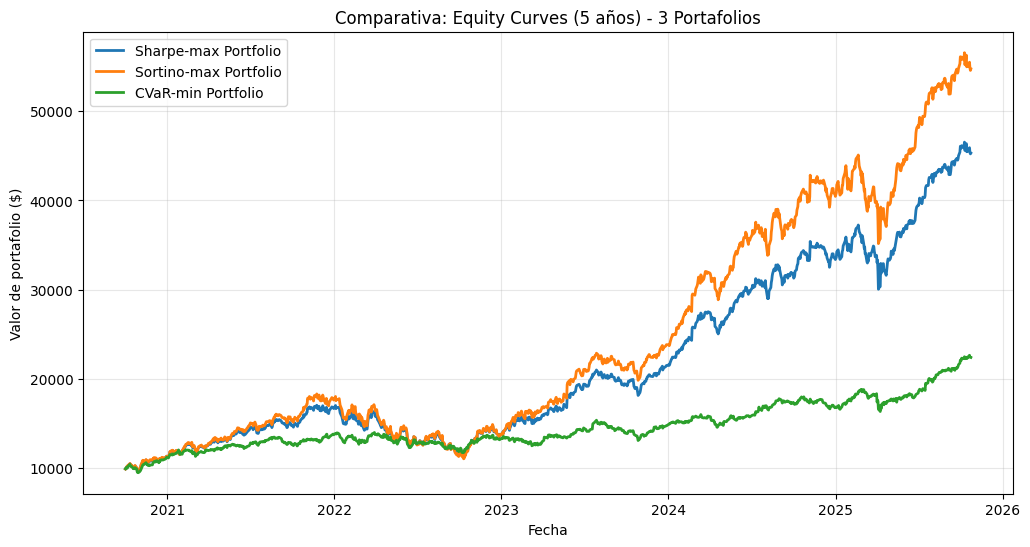

In [56]:
# Función para calcular series de acciones a partir de rendimientos y ponderaciones históricas
def equity_series_from_weights(weights, prices, initial_capital=10000):
    daily_ret = prices.pct_change().dropna()
    port_daily = daily_ret.dot(weights)
    equity = (1 + port_daily).cumprod() * initial_capital
    return equity

weights_sortino_arr = w_sortino
weights_cvar_arr = w_cvar
weights_sharpe_arr = list(w_sharpe.values())

eq_sortino = equity_series_from_weights(weights_sortino_arr, prices, initial_capital=10000)
eq_cvar = equity_series_from_weights(weights_cvar_arr, prices, initial_capital=10000)
eq_sharpe = equity_series_from_weights(weights_sharpe_arr, prices, initial_capital=10000)

plt.figure(figsize=(12,6))
plt.plot(eq_sharpe.index, eq_sharpe.values, label='Sharpe-max Portfolio', linewidth=2)
plt.plot(eq_sortino.index, eq_sortino.values, label='Sortino-max Portfolio', linewidth=2)
plt.plot(eq_cvar.index, eq_cvar.values, label='CVaR-min Portfolio', linewidth=2)
plt.title("Comparativa: Equity Curves (5 años) - 3 Portafolios")
plt.ylabel("Valor de portafolio ($)")
plt.xlabel("Fecha")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Interpretación visual: observa divergencias, drawdowns y recuperación relativa de cada enfoque.

### 9️⃣ Métricas resumidas

### Calcular y mostrar las métricas clave para las 3 carteras: Return anual, Volatilidad anual, Sharpe, Sortino (manual), Max Drawdown.

In [61]:
def annual_metrics(equity_series, rf=rf_annual):
    # equity_series: pandas Serie de capital acumulado
    daily_ret = equity_series.pct_change().dropna()
    ann_ret = (1 + daily_ret.mean())**252 - 1
    ann_vol = daily_ret.std() * np.sqrt(252)
    sharpe = (ann_ret - rf) / ann_vol if ann_vol>0 else np.nan
    # Sortino: desviación bajista vs rf_daily
    rf_daily = (1+rf)**(1/252)-1
    dd = downside_deviation(daily_ret, target=rf_daily)
    sortino = (daily_ret.mean() - rf_daily) / dd if dd>0 else np.nan
    # Max drawdown
    running_max = equity_series.cummax()
    drawdown = (equity_series - running_max) / running_max
    max_dd = drawdown.min()
    return {"AnnRet":ann_ret, "AnnVol":ann_vol, "Sharpe":sharpe, "Sortino":sortino, "MaxDrawdown":max_dd}

metrics_sharpe = annual_metrics(eq_sharpe)
metrics_sortino = annual_metrics(eq_sortino)
metrics_cvar = annual_metrics(eq_cvar)

pd.DataFrame([metrics_sharpe, metrics_sortino, metrics_cvar],
             index=["Sharpe_Portfolio","Sortino_Portfolio","CVaR_Portfolio"]).round(4)

,AnnRet,AnnVol,Sharpe,Sortino,MaxDrawdown
Sharpe_Portfolio,0.3817,0.2071,1.6501,0.1317,-0.3405
Sortino_Portfolio,0.4453,0.2394,1.6929,0.1330,-0.3974
CVaR_Portfolio,0.1881,0.1463,1.0127,0.0827,-0.1620


### 🔟 Parte II — Optimización con restricciones del mundo real
###Problema: las carteras “libres” a menudo asignan pesos extremos (ej. 0% a JPM, 50% a NVDA). En gestión real hay límites y reglas.

#### A) Restricciones de peso por activo

#### Ejemplo: limitar a 30% máximo por activo.

In [64]:
# Tomemos la cartera max Sharpe como base y rehacemos con restricciones
ef_restricted = EfficientFrontier(mu, S)
# Añadir constraint: ninguno > 0.30
for i, t in enumerate(tickers):
    ef_restricted.add_constraint(lambda w, i=i: w[i] <= 0.30)

# Long-only y suma a 1 implícitos en ef
ef_restricted.max_sharpe()
w_restricted = ef_restricted.clean_weights()
print("Pesos (restringidos 30% max):", w_restricted)

Pesos (restringidos 30% max): OrderedDict({'AAPL': 0.1, 'JNJ': 0.3, 'JPM': 0.3, 'NVDA': 0.3})


#### B) Restricciones sectoriales (ejemplo)

#### Preparar sectores y aplicar límites: (NVDA,AAPL → Tecnología; JNJ → Salud; JPM → Finanzas). Limitamos tecnología a máximo 50% y salud mínimo 10%.

In [89]:
# Definir límites por sector
sector_mapper = {"NVDA": "Technology", "AAPL": "Technology",
                 "JNJ": "Health", "JPM": "Financials"}

sector_lower = {"Technology": 0.0, "Health": 0.1, "Financials": 0.0}
sector_upper = {"Technology": 0.30, "Health": 0.28, "Financials": 1.0}

ef_sector = EfficientFrontier(mu, S)
ef_sector.add_sector_constraints(sector_mapper, sector_lower, sector_upper)

ef_sector.max_sharpe()
w_sector = ef_sector.clean_weights()
print("Pesos (sector-constrained):", w_sector)

# Verificación
tech_weight = sum(w_sector[t] for t in ["NVDA", "AAPL"])
health_weight = sum(w_sector[t] for t in ["JNJ"])
print(f"\nTecnología: {tech_weight:.2%} | Salud: {health_weight:.2%}")

Pesos (sector-constrained): OrderedDict({'AAPL': 0.0, 'JNJ': 0.28, 'JPM': 0.42, 'NVDA': 0.3})

Tecnología: 30.00% | Salud: 28.00%


Nota: add_sector_constraints() existe en algunas versiones de pypfopt; la forma mostrada usa add_constraint con sumatorias para mayor compatibilidad.

### 1️⃣1️⃣ Comparativa final: libre vs. restringida

In [72]:
# Calcular equity curve para carteras restringidas y con restricciones sectoriales
weights_restricted_arr = list(w_restricted.values())
weights_sector_arr = list(w_sector.values())

eq_restricted = equity_series_from_weights(weights_restricted_arr, prices, initial_capital=10000)
eq_sector = equity_series_from_weights(weights_sector_arr, prices, initial_capital=10000)

# Calcular métricas para carteras restringidas y con restricciones sectoriales
metrics_restricted = annual_metrics(eq_restricted)
metrics_sector = annual_metrics(eq_sector)

### Resumen de Pesos de Portafolio

Aquí se muestra una tabla con los pesos asignados a cada activo en los diferentes portafolios optimizados:

In [93]:
weights_summary = pd.DataFrame({
    "Sharpe (Libre)": w_sharpe,
    "Sharpe (Restringido)": w_restricted,
    "Sharpe (Sector-Constrained)": w_sector
}).T

# Formatear pesos como porcentajes
def format_weights_as_percentage(df):
    return df.map(lambda x: f"{x:.2%}" if isinstance(x, (int, float)) else x)

display(format_weights_as_percentage(weights_summary))

,AAPL,JNJ,JPM,NVDA
Sharpe (Libre),0.00%,34.96%,36.36%,28.68%
Sharpe (Restringido),10.00%,30.00%,30.00%,30.00%
Sharpe (Sector-Constrained),0.00%,28.00%,42.00%,30.00%


### Resumen de Métricas de Rendimiento y Riesgo

Aquí se presenta una tabla comparativa de las métricas clave para cada portafolio:

In [95]:
metrics_summary = pd.DataFrame([metrics_sharpe, metrics_restricted, metrics_sector],
             index=["Sharpe (Libre)","Sharpe (Restringido)","Sharpe (Sector-Constrained)"]).round(4)

display(metrics_summary)

,AnnRet,AnnVol,Sharpe,Sortino,MaxDrawdown
Sharpe (Libre),0.3817,0.2071,1.6501,0.1317,-0.3405
Sharpe (Restringido),0.3919,0.2171,1.6206,0.1289,-0.3435
Sharpe (Sector-Constrained),0.3817,0.2071,1.6501,0.1317,-0.3405


### Comentarios sobre los Portafolios

*   **Sharpe (Libre):** Esta cartera busca maximizar el retorno ajustado por volatilidad sin ninguna restricción artificial sobre los pesos de los activos. A menudo, puede resultar en carteras muy concentradas en los activos con mejor desempeño histórico o menor correlación.

*   **Sharpe (Restringido):** Al añadir restricciones, como un límite máximo de peso por activo (ej. 30% como en el ejemplo), se fuerza a la cartera a ser más diversificada, reduciendo la concentración. Esto puede llevar a un Sharpe Ratio ligeramente menor que la cartera libre, pero también a una menor volatilidad y Max Drawdown.

*   **Sharpe (Sector-Constrained):** Las restricciones sectoriales buscan limitar la exposición a ciertos sectores o asegurar una asignación mínima a otros. Esto añade otra capa de diversificación y control de riesgo, reflejando consideraciones prácticas en la gestión de portafolios. Al igual que las restricciones por activo, pueden resultar en un Sharpe Ratio un poco menor que la cartera libre, pero con perfiles de riesgo potencialmente más manejables.

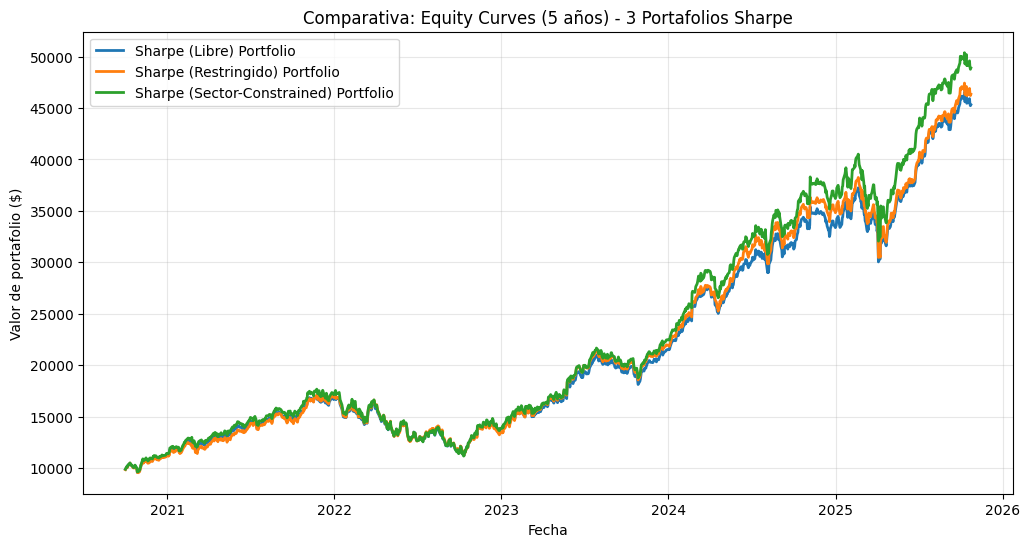

In [98]:
# Función para calcular series de acciones a partir de rendimientos y ponderaciones históricas
def equity_series_from_weights(weights, prices, initial_capital=10000):
    daily_ret = prices.pct_change().dropna()
    port_daily = daily_ret.dot(weights)
    equity = (1 + port_daily).cumprod() * initial_capital
    return equity

weights_sharpe_arr = list(w_sharpe.values())
weights_restricted_arr = list(w_restricted.values())
weights_sector_arr = list(w_sector.values())

eq_sharpe = equity_series_from_weights(weights_sharpe_arr, prices, initial_capital=10000)
eq_restricted = equity_series_from_weights(weights_restricted_arr, prices, initial_capital=10000)
eq_sector = equity_series_from_weights(weights_sector_arr, prices, initial_capital=10000)

plt.figure(figsize=(12,6))
plt.plot(eq_sharpe.index, eq_sharpe.values, label='Sharpe (Libre) Portfolio', linewidth=2)
plt.plot(eq_restricted.index, eq_restricted.values, label='Sharpe (Restringido) Portfolio', linewidth=2)
plt.plot(eq_sector.index, eq_sector.values, label='Sharpe (Sector-Constrained) Portfolio', linewidth=2)

plt.title("Comparativa: Equity Curves (5 años) - 3 Portafolios Sharpe")
plt.ylabel("Valor de portafolio ($)")
plt.xlabel("Fecha")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [58]:
# ================================================================================================

### 1️⃣2️⃣ Conclusión y extensiones.

#### Resumen breve:

#### •	pypfopt + yfinance permiten pasar de precios a carteras optimizadas rápidamente.

#### •	Optimizar por Sortino o minimizar CVaR cambia el perfil del portafolio: protección contra pérdidas vs maximizar ratio clásico de Sharpe.

#### •	Traducir pesos a órdenes reales (DiscreteAllocation) acorta la brecha entre teoría y ejecución.

#### •	Restricciones del mundo real (límites por activo y sector) producen carteras más prácticas y reguladas, con trade-off entre eficiencia teórica y robustez operativa.

<br/>

#### Extensiones prácticas:

#### •	Backtesting con rebalanceo periódico de estas carteras.

#### •	Incluir comisiones y slippage en DiscreteAllocation y simulaciones.

#### •	Evaluar robustez mediante bootstrap y walk-forward.

#### •	Añadir factores (momentum, value) y optimizar por métricas alternativas (Sortino con target, Sortino penalizado por turnover).

Descargo de responsabilidad:

Este artículo es puramente informativo y no constituye asesoramiento financiero. No se recomienda tomar decisiones de inversión basadas únicamente en esta información. Se aconseja realizar un análisis propio y consultar a un profesional financiero antes de tomar decisiones de inversión. Las decisiones de inversión son responsabilidad exclusiva del lector.

En todo momento se incita a hacer un análisis propio, y saber que tus decisiones son completamente tuyas y afectan tus inversiones y tu patrimonio.

● No es una asesoría financiera.

● No supone en ningún caso, esto sea recomendación de inversión, de compra o de venta de ningún activo/bien o subyacente.

● El contenido del articulo es meramente informativo.

● En todo momento se incita a hacer un análisis propio, y saber que tus decisiones son completamente tuyas y afectan tus inversiones y tu patrimonio.